In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

# prepare dataframe for analysis

files_sources = {
    '../Output_Data/CS/CS_FT_prepped_20240514_205217_discrete.csv': 'FT',
    '../Output_Data/CS/CS_CNBC_prepped_20240514_203705_discrete.csv': 'CNBC',
    '../Output_Data/CS/CS_NZZ_prepped_20240515_010305_discrete.csv': 'NZZ',
    '../Output_Data/CS/CS_NZZ_prepped_correction_20240516_165837_discrete.csv': 'NZZ',
    '../Output_Data/CS/CS_SRF_prepped_20240515_050307_discrete.csv': 'SRF'
}

In [2]:
# Columns to keep
columns_to_keep = ["text_date", "Sentiment", "news_source"]

# Load datasets with a new 'news_source' column
data_frames = []
for file_path, source in files_sources.items():
    df = pd.read_csv(file_path)
    df['news_source'] = source  # Add news_source column
    # Select only the columns to keep
    df = df[columns_to_keep]
    data_frames.append(df)



In [3]:
# Merge all dataframes into a single dataframe
merged_df = pd.concat(data_frames)


In [4]:
# order by date
merged_df = merged_df.sort_values(by='text_date')

In [6]:
merged_df.tail()

,text_date,Sentiment,news_source
1024,2023-06-28 00:00:00+00:00,-1. Article focuses on significant job cuts an...,NZZ
1023,2023-06-28 00:00:00+00:00,-1. The article highlights mismanagement and l...,NZZ
1026,2023-06-29 00:00:00+00:00,-1. Article highlights significant pre-tax los...,NZZ
1153,2023-06-29 00:00:00+00:00,"-1. Article highlights Credit Suisse's losses,...",FT
1154,2023-06-30 00:00:00+00:00,1. Credit Suisse analyst provides positive ins...,FT


In [7]:
# Extract numerical sentiment scores from the 'Sentiment' column
merged_df['Sentiment_score'] = merged_df['Sentiment'].str.extract(r"(-?\d\.?\d*)\.").astype(float)

In [9]:
# Convert 'text_date' to datetime format handling ISO8601 with timezone
merged_df['text_date'] = pd.to_datetime(merged_df['text_date'], errors='coerce', utc=True)

# Convert datetime to 'dd.mm.yyyy' format without time only after all datetime manipulations are done
merged_df['formatted_date'] = merged_df['text_date'].dt.strftime('%d.%m.%Y')

In [10]:
merged_df.head()

,text_date,Sentiment,news_source,Sentiment_score,formatted_date
0,2019-01-03 00:00:00+00:00,"-1. Describes challenges, risk reduction, and ...",NZZ,-1.0,03.01.2019
0,2019-01-04 00:00:00+00:00,-1. Article highlights Credit Suisse's complia...,FT,-1.0,04.01.2019
1,2019-01-04 00:00:00+00:00,-1. Article highlights fraudulent activities a...,FT,-1.0,04.01.2019
1,2019-01-04 00:00:00+00:00,-1. Article implicates Credit Suisse in fraud ...,NZZ,-1.0,04.01.2019
0,2019-01-04 13:19:00+00:00,-1. Article implicates Credit Suisse employees...,SRF,-1.0,04.01.2019


In [11]:
len(merged_df)

2717

In [12]:
merged_df

,text_date,Sentiment,news_source,Sentiment_score,formatted_date
0,2019-01-03 00:00:00+00:00,"-1. Describes challenges, risk reduction, and ...",NZZ,-1.0,03.01.2019
0,2019-01-04 00:00:00+00:00,-1. Article highlights Credit Suisse's complia...,FT,-1.0,04.01.2019
1,2019-01-04 00:00:00+00:00,-1. Article highlights fraudulent activities a...,FT,-1.0,04.01.2019
1,2019-01-04 00:00:00+00:00,-1. Article implicates Credit Suisse in fraud ...,NZZ,-1.0,04.01.2019
0,2019-01-04 13:19:00+00:00,-1. Article implicates Credit Suisse employees...,SRF,-1.0,04.01.2019
...,...,...,...,...,...
1024,2023-06-28 00:00:00+00:00,-1. Article focuses on significant job cuts an...,NZZ,-1.0,28.06.2023
1023,2023-06-28 00:00:00+00:00,-1. The article highlights mismanagement and l...,NZZ,-1.0,28.06.2023
1026,2023-06-29 00:00:00+00:00,-1. Article highlights significant pre-tax los...,NZZ,-1.0,29.06.2023
1153,2023-06-29 00:00:00+00:00,"-1. Article highlights Credit Suisse's losses,...",FT,-1.0,29.06.2023


In [13]:
# Calculate daily average sentiment scores and create a new column 'D_AVG'
daily_sentiment = merged_df.groupby(merged_df['text_date'].dt.date).agg({
    'Sentiment_score': 'mean'  # Calculate the mean of Sentiment_score
}).reset_index().rename(columns={'Sentiment_score': 'D_AVG', 'text_date': 'Date'})

In [14]:
# Determine dummy variables based on the daily average sentiment score
daily_sentiment['Positive_sentiment'] = np.where(daily_sentiment['D_AVG'] >= 1/3, 1, 0)
daily_sentiment['Negative_sentiment'] = np.where(daily_sentiment['D_AVG'] <= -1/3, 1, 0)
daily_sentiment['Positive_sentiment_0'] = np.where(daily_sentiment['D_AVG'] >= 0, 1, 0)
daily_sentiment['Negative_sentiment_0'] = np.where(daily_sentiment['D_AVG'] <= 0, 1, 0)


In [15]:
# Convert 'Date' to datetime format
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], format='%Y-%m-%d', errors='coerce')

In [16]:
daily_sentiment

,Date,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
0,2019-01-03,-1.0,0,1,0,1
1,2019-01-04,-1.0,0,1,0,1
2,2019-01-08,0.0,0,0,1,1
3,2019-01-09,-1.0,0,1,0,1
4,2019-01-10,-1.0,0,1,0,1
...,...,...,...,...,...,...
954,2023-06-26,-1.0,0,1,0,1
955,2023-06-27,-1.0,0,1,0,1
956,2023-06-28,-1.0,0,1,0,1
957,2023-06-29,-1.0,0,1,0,1


In [17]:
len(daily_sentiment)

959

In [23]:
# export csv files
merged_df.to_csv('merged_df_creditsuisse.csv', index=False)
daily_sentiment.to_csv('daily_sentiment_creditsuisse.csv', index=False)

In [18]:
# Read in financial data
cs_stocks = pd.read_csv('CS_stocks.csv', sep=";")

In [19]:
# Convert 'Date' column to datetime format (dd.mm.yyyy)
cs_stocks['Date'] = pd.to_datetime(cs_stocks['Date'], format='%d.%m.%Y', errors='coerce')

In [20]:
cs_stocks

,Date,PX_LAST,PX_VOLUME
0,2023-06-13,0.8500,NaN
1,2023-06-12,0.8170,41897477.0
2,2023-06-09,0.8080,19615617.0
3,2023-06-08,0.8110,20919821.0
4,2023-06-07,0.8102,20326119.0
...,...,...,...
1116,2019-01-08,10.7008,9701932.0
1117,2019-01-07,10.5777,10016894.0
1118,2019-01-04,10.5399,15734558.0
1119,2019-01-03,10.2606,11390314.0


In [22]:
# Calculate log returns (shift(-1) because dataframe is in descending order)
cs_stocks['Log_Return'] = np.log(cs_stocks['PX_LAST'] / cs_stocks['PX_LAST'].shift(-1))

In [23]:
cs_stocks

,Date,PX_LAST,PX_VOLUME,Log_Return
0,2023-06-13,0.8500,NaN,0.039597
1,2023-06-12,0.8170,41897477.0,0.011077
2,2023-06-09,0.8080,19615617.0,-0.003706
3,2023-06-08,0.8110,20919821.0,0.000987
4,2023-06-07,0.8102,20326119.0,0.000741
...,...,...,...,...
1116,2019-01-08,10.7008,9701932.0,0.011570
1117,2019-01-07,10.5777,10016894.0,0.003580
1118,2019-01-04,10.5399,15734558.0,0.026857
1119,2019-01-03,10.2606,11390314.0,0.003691


In [24]:
# Drop the last row with NaN return
cs_stocks = cs_stocks.dropna(subset=['Log_Return'])

In [25]:
#Create a complete date range
date_range = pd.date_range(start=min(cs_stocks['Date'].min(), daily_sentiment['Date'].min()),
                           end=max(cs_stocks['Date'].max(), daily_sentiment['Date'].max()))

# Reindex the datasets to this date range
cs_stocks = cs_stocks.set_index('Date').reindex(date_range).ffill().reset_index().rename(columns={'index': 'Date'})
daily_sentiment = daily_sentiment.set_index('Date').reindex(date_range).fillna({'D_AVG': 0, 'Positive_sentiment': 0, 'Negative_sentiment': 0, 'Positive_sentiment_0': 0, 'Negative_sentiment_0': 0}).reset_index().rename(columns={'index': 'Date'})

In [26]:
# Merge datasets on date
merged_data = pd.merge(cs_stocks, daily_sentiment, on='Date', how='inner')

In [27]:
merged_data

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
0,2019-01-03,10.2606,11390314.0,0.003691,-1.0,0.0,1.0,0.0,1.0
1,2019-01-04,10.5399,15734558.0,0.026857,-1.0,0.0,1.0,0.0,1.0
2,2019-01-05,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0
3,2019-01-06,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0
4,2019-01-07,10.5777,10016894.0,0.003580,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1635,2023-06-26,0.8500,41897477.0,0.039597,-1.0,0.0,1.0,0.0,1.0
1636,2023-06-27,0.8500,41897477.0,0.039597,-1.0,0.0,1.0,0.0,1.0
1637,2023-06-28,0.8500,41897477.0,0.039597,-1.0,0.0,1.0,0.0,1.0
1638,2023-06-29,0.8500,41897477.0,0.039597,-1.0,0.0,1.0,0.0,1.0


In [28]:
len(merged_data)

1640

In [29]:
# Filter merged_data by the date range 2019-01-01 to 2023-03-12
filtered_start_date = '2019-01-01'
filtered_end_date = '2023-03-17'
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data[(merged_data['Date'] >= filtered_start_date) & (merged_data['Date'] <= filtered_end_date)]

In [35]:
merged_data

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
0,2019-01-03,10.2606,11390314.0,0.003691,-1.000000,0.0,1.0,0.0,1.0
1,2019-01-04,10.5399,15734558.0,0.026857,-1.000000,0.0,1.0,0.0,1.0
2,2019-01-05,10.5399,15734558.0,0.026857,0.000000,0.0,0.0,0.0,0.0
3,2019-01-06,10.5399,15734558.0,0.026857,0.000000,0.0,0.0,0.0,0.0
4,2019-01-07,10.5777,10016894.0,0.003580,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1530,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0
1531,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0
1532,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0
1533,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0


### Analysis

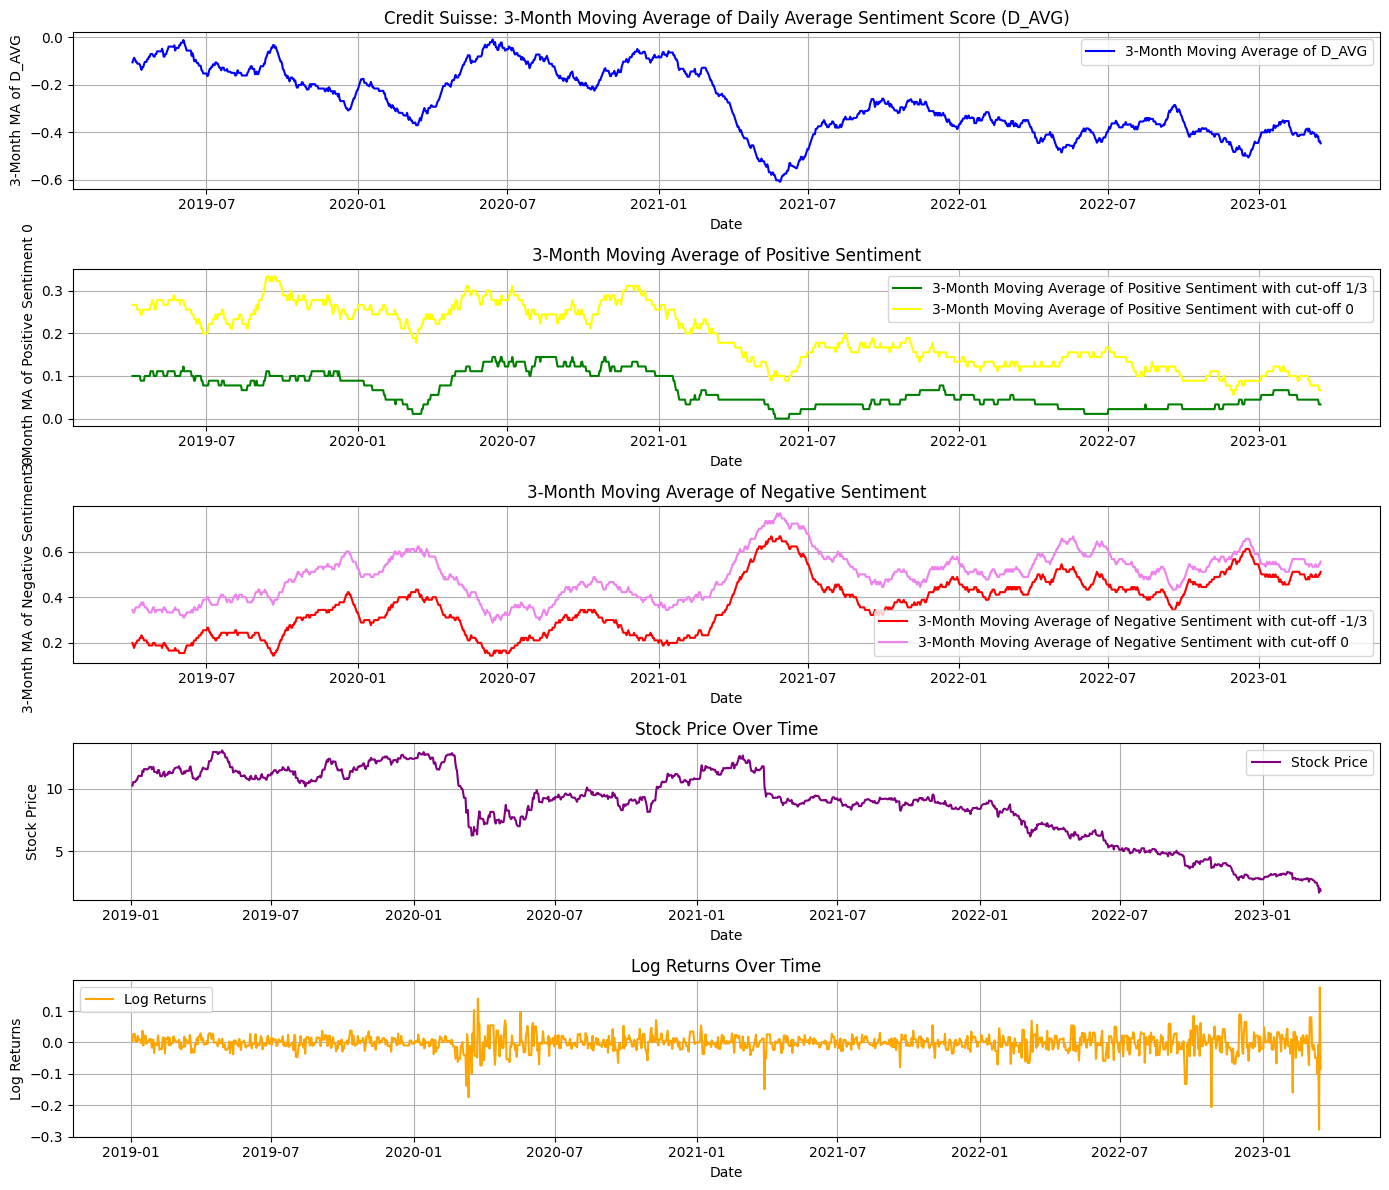

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
#create copy of merged_data
merged_data_plots = merged_data.copy()
# Assuming merged_data is already defined and contains the relevant columns

# Calculate the 3-month (90-day) moving averages
merged_data_plots['D_AVG_MA_3M'] = merged_data_plots['D_AVG'].rolling(window=90).mean()
merged_data_plots['Positive_sentiment_MA_3M'] = merged_data_plots['Positive_sentiment'].rolling(window=90).mean()
merged_data_plots['Negative_sentiment_MA_3M'] = merged_data_plots['Negative_sentiment'].rolling(window=90).mean()
merged_data_plots['Positive_sentiment_0_MA_3M'] = merged_data_plots['Positive_sentiment_0'].rolling(window=90).mean()
merged_data_plots['Negative_sentiment_0_MA_3M'] = merged_data_plots['Negative_sentiment_0'].rolling(window=90).mean()

# Plot the 3-month moving averages, stock price, and log returns
plt.figure(figsize=(14, 12))

# Plot for D_AVG
plt.subplot(5, 1, 1)
plt.plot(merged_data_plots['Date'], merged_data_plots['D_AVG_MA_3M'], label='3-Month Moving Average of D_AVG', color='blue')
plt.xlabel('Date')
plt.ylabel('3-Month MA of D_AVG')
plt.title('Credit Suisse: 3-Month Moving Average of Daily Average Sentiment Score (D_AVG)')
plt.legend()
plt.grid(True)

# Plot for Positive_sentiment
plt.subplot(5, 1, 2)
plt.plot(merged_data_plots['Date'], merged_data_plots['Positive_sentiment_MA_3M'], label='3-Month Moving Average of Positive Sentiment with cut-off 1/3', color='green')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Positive Sentiment')
plt.title('3-Month Moving Average of Positive Sentiment')
plt.legend()
plt.grid(True)

# Plot for Negative_sentiment
plt.subplot(5, 1, 3)
plt.plot(merged_data_plots['Date'], merged_data_plots['Negative_sentiment_MA_3M'], label='3-Month Moving Average of Negative Sentiment with cut-off -1/3', color='red')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Negative Sentiment')
plt.title('3-Month Moving Average of Negative Sentiment')
plt.legend()
plt.grid(True)


# Plot for Positive_sentiment
plt.subplot(5, 1, 2)
plt.plot(merged_data_plots['Date'], merged_data_plots['Positive_sentiment_0_MA_3M'], label='3-Month Moving Average of Positive Sentiment with cut-off 0', color='yellow')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Positive Sentiment 0')
plt.title('3-Month Moving Average of Positive Sentiment')
plt.legend()
plt.grid(True)

# Plot for Negative_sentiment
plt.subplot(5, 1, 3)
plt.plot(merged_data_plots['Date'], merged_data_plots['Negative_sentiment_0_MA_3M'], label='3-Month Moving Average of Negative Sentiment with cut-off 0', color='violet')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Negative Sentiment 0')
plt.title('3-Month Moving Average of Negative Sentiment')
plt.legend()
plt.grid(True)



# Plot for stock price
plt.subplot(5, 1, 4)
plt.plot(merged_data_plots['Date'], merged_data_plots['PX_LAST'], label='Stock Price', color='purple')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.grid(True)

# Plot for log returns
plt.subplot(5, 1, 5)
plt.plot(merged_data_plots['Date'], merged_data_plots['Log_Return'], label='Log Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Log Returns Over Time')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


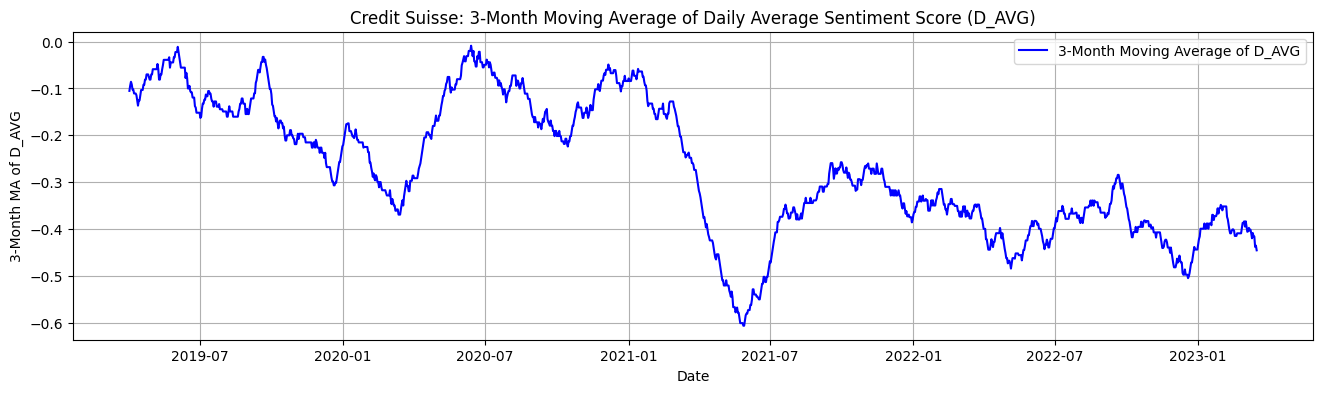

In [31]:
# Create a separate plot for the 3-month moving average of D_AVG
plt.figure(figsize=(16, 4))
plt.plot(merged_data_plots['Date'], merged_data_plots['D_AVG_MA_3M'], label='3-Month Moving Average of D_AVG', color='blue')
plt.xlabel('Date')
plt.ylabel('3-Month MA of D_AVG')
plt.title('Credit Suisse: 3-Month Moving Average of Daily Average Sentiment Score (D_AVG)')
plt.legend()
plt.grid(True)
plt.show()

ACF values: [ 1.00000000e+00  2.20632522e-01  1.65606853e-01 -2.94402078e-02
 -4.21725256e-03 -3.70521762e-03  1.82947764e-02  2.97846830e-02
 -3.61381032e-02  2.63451034e-03 -2.58286767e-02  3.47802664e-02
 -4.43164561e-02 -2.45577776e-04 -9.44142787e-02 -5.97529751e-02
 -2.93327193e-02  4.36784471e-03 -1.90904324e-02 -4.79557562e-03
  1.81171665e-03  5.74625338e-03  2.57397898e-02 -3.85352116e-02
 -2.67060493e-02 -6.16680086e-02 -4.23731820e-02 -1.84277603e-02
  6.67574123e-03  2.58799586e-02  4.33862188e-02 -2.74094723e-02]


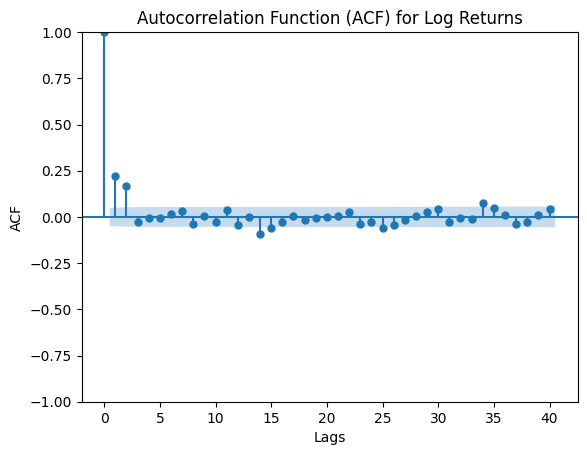

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming 'merged_data' already contains the 'Log_Return' column

# Calculate ACF values for the log stock returns
acf_values = sm.tsa.stattools.acf(merged_data['Log_Return'], fft=False)

# Print the ACF values
print("ACF values:", acf_values)

# Plot the ACF
plot_acf(merged_data['Log_Return'], lags=40)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

PACF values: [ 1.00000000e+00  2.20776351e-01  1.23079897e-01 -9.47591107e-02
 -7.58681616e-04  1.85043842e-02  1.45859742e-02  2.18731530e-02
 -5.56248727e-02  1.61007310e-02 -1.20820326e-02  3.75323861e-02
 -5.79462930e-02  5.45908020e-03 -8.17219043e-02 -3.06892460e-02
  1.48373678e-02  1.19913339e-02 -3.36644983e-02  7.15367215e-03
  8.65891986e-03  1.21985294e-02  1.36085477e-02 -5.32740581e-02
 -2.22804022e-02 -2.95492004e-02 -3.08328763e-02  4.95504299e-03
  5.13345077e-03  1.82823891e-02  3.51983216e-02 -5.27911847e-02
  2.34570471e-03  3.50759186e-03  8.57205910e-02  1.40593890e-02
 -3.01399944e-02 -4.59445764e-02 -3.77152005e-03  2.25134054e-02
  2.97458572e-02]


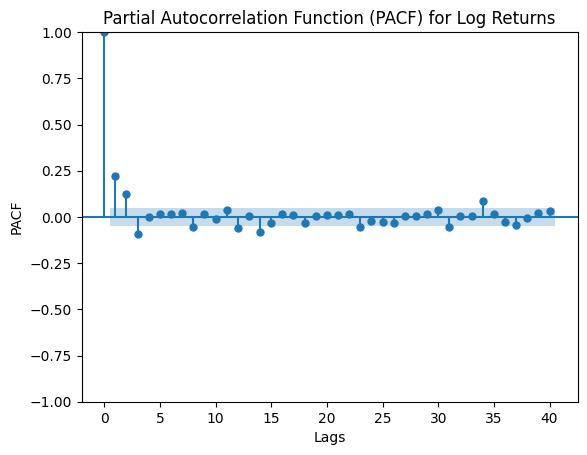

In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Assuming 'merged_data' already contains the 'Log_Return' column

# Calculate PACF values for the log stock returns
pacf_values = sm.tsa.stattools.pacf(merged_data['Log_Return'], method='yw', nlags=40)

# Print the PACF values
print("PACF values:", pacf_values)

# Plot the PACF
plot_pacf(merged_data['Log_Return'], lags=40, method='yw')  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

### Models

In [34]:
merged_data_a1 = merged_data.copy()

In [35]:
merged_data_a1.loc[:, 'Log_Return_Lag1'] = merged_data_a1['Log_Return'].shift(1)
merged_data_a1.loc[:, 'Log_Return_Lag2'] = merged_data_a1['Log_Return'].shift(2)
merged_data_a1.loc[:, 'Log_Return_Lag3'] = merged_data_a1['Log_Return'].shift(3)
merged_data_a1.loc[:, 'Log_Return_Lag8'] = merged_data_a1['Log_Return'].shift(8)



In [36]:
merged_data_a1.head()

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Log_Return_Lag1,Log_Return_Lag2,Log_Return_Lag3,Log_Return_Lag8
0,2019-01-03,10.2606,11390314.0,0.003691,-1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN
1,2019-01-04,10.5399,15734558.0,0.026857,-1.0,0.0,1.0,0.0,1.0,0.003691,NaN,NaN,NaN
2,2019-01-05,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0,0.026857,0.003691,NaN,NaN
3,2019-01-06,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0,0.026857,0.026857,0.003691,NaN
4,2019-01-07,10.5777,10016894.0,0.003580,0.0,0.0,0.0,0.0,0.0,0.026857,0.026857,0.026857,NaN


In [37]:


# Drop rows with NaN values created by the shift operation
merged_data_a1.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a1[['Positive_sentiment', 'Negative_sentiment', 'Log_Return_Lag1', 'Log_Return_Lag2','Log_Return_Lag3', 'Log_Return_Lag8']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a1['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     9.776
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.36e-10
Time:                        05:40:58   Log-Likelihood:                 3383.3
No. Observations:                1527   AIC:                            -6753.
Df Residuals:                    1520   BIC:                            -6715.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0009      0

In [38]:
merged_data_a2 = merged_data.copy()
#Lag variables
merged_data_a2.loc[:, 'Log_Return_Lag1'] = merged_data_a2['Log_Return'].shift(1)
merged_data_a2.loc[:, 'Log_Return_Lag2'] = merged_data_a2['Log_Return'].shift(2)
merged_data_a2.loc[:, 'Log_Return_Lag3'] = merged_data_a2['Log_Return'].shift(3)
merged_data_a2.loc[:, 'Positive_sentiment_Lag1'] = merged_data_a2['Positive_sentiment'].shift(1)
merged_data_a2.loc[:, 'Positive_sentiment_0_Lag1'] = merged_data_a2['Positive_sentiment_0'].shift(1)
merged_data_a2.loc[:, 'Negative_sentiment_Lag1'] = merged_data_a2['Negative_sentiment'].shift(1)
merged_data_a2.loc[:, 'Negative_sentiment_0_Lag1'] = merged_data_a2['Negative_sentiment_0'].shift(1)


# Drop rows with NaN values created by the shift operation
merged_data_a2.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment', 'Negative_sentiment', 'Positive_sentiment_Lag1', 'Negative_sentiment_Lag1', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag3']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     8.366
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           4.63e-10
Time:                        05:41:01   Log-Likelihood:                 3394.4
No. Observations:                1532   AIC:                            -6773.
Df Residuals:                    1524   BIC:                            -6730.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [50]:
merged_data_a2

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Log_Return_Lag1,Log_Return_Lag2,Log_Return_Lag3,Positive_sentiment_Lag1,Positive_sentiment_0_Lag1,Negative_sentiment_Lag1,Negative_sentiment_0_Lag1
3,2019-01-06,10.5399,15734558.0,0.026857,0.000000,0.0,0.0,0.0,0.0,0.026857,0.026857,0.003691,0.0,0.0,0.0,0.0
4,2019-01-07,10.5777,10016894.0,0.003580,0.000000,0.0,0.0,0.0,0.0,0.026857,0.026857,0.026857,0.0,0.0,0.0,0.0
5,2019-01-08,10.7008,9701932.0,0.011570,0.000000,0.0,0.0,1.0,1.0,0.003580,0.026857,0.026857,0.0,0.0,0.0,0.0
6,2019-01-09,10.7197,11755882.0,0.001765,-1.000000,0.0,1.0,0.0,1.0,0.011570,0.003580,0.026857,0.0,1.0,0.0,1.0
7,2019-01-10,10.9422,11896505.0,0.020544,-1.000000,0.0,1.0,0.0,1.0,0.001765,0.011570,0.003580,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0,-0.049629,-0.049629,-0.049629,0.0,0.0,0.0,0.0
1531,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0,-0.100653,-0.049629,-0.049629,0.0,0.0,1.0,1.0
1532,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0,-0.007561,-0.100653,-0.049629,0.0,0.0,1.0,1.0
1533,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0,-0.277614,-0.007561,-0.100653,0.0,0.0,1.0,1.0


In [39]:
# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment_0', 'Negative_sentiment_0', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag3']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     10.07
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.68e-09
Time:                        05:41:05   Log-Likelihood:                 3392.8
No. Observations:                1532   AIC:                            -6774.
Df Residuals:                    1526   BIC:                            -6742.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0002 

In [40]:
# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment_0', 'Negative_sentiment_0','Positive_sentiment_0_Lag1', 'Negative_sentiment_0_Lag1', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag3']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     7.240
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.49e-08
Time:                        05:41:07   Log-Likelihood:                 3393.2
No. Observations:                1532   AIC:                            -6770.
Df Residuals:                    1524   BIC:                            -6728.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### index

In [41]:
# Load the stock index data with the correct delimiter
mxeu_df = pd.read_csv('MXEU.csv', delimiter=';')
smi_df = pd.read_csv('SMI.csv', delimiter=';')
spx_df = pd.read_csv('SPX.csv', delimiter=';')
sx7p_df = pd.read_csv('SX7P.csv', delimiter=';')





In [54]:
mxeu_df.head()

,Date,PX_LAST,PX_VOLUME
0,24.05.2024,173.01550,1.453675e+09
1,23.05.2024,173.02624,1.577289e+09
2,22.05.2024,173.06490,1.435591e+09
3,21.05.2024,173.26201,1.494578e+09
4,20.05.2024,173.47093,1.124512e+09


In [42]:


# Define fixed start and end dates
start_date = '2019-01-01'
end_date = '2023-03-17'
date_range = pd.date_range(start=start_date, end=end_date)

# Function to reindex and fill missing data
def reindex_and_fill(df, date_col='Date'):
    df[date_col] = pd.to_datetime(df[date_col],dayfirst=True,errors='coerce')
    df = df.drop_duplicates(subset=date_col)
    df = df.set_index(date_col).reindex(date_range).ffill().reset_index().rename(columns={'index': date_col})
    return df

# Reindex and fill missing data for stock index dataframes
mxeu_df = reindex_and_fill(mxeu_df)
smi_df = reindex_and_fill(smi_df)
spx_df = reindex_and_fill(spx_df)
sx7p_df = reindex_and_fill(sx7p_df)

# Calculate the natural logarithm of the index prices
mxeu_df['Log_MXEU'] = np.log(mxeu_df['PX_LAST'])
smi_df['Log_SMI'] = np.log(smi_df['PX_LAST'])
spx_df['Log_SPX'] = np.log(spx_df['PX_LAST'])
sx7p_df['Log_SX7P'] = np.log(sx7p_df['PX_LAST'])

# Calculate the difference in log to get log returns
mxeu_df['Log_Return_MXEU'] = mxeu_df['Log_MXEU'].diff()
smi_df['Log_Return_SMI'] = smi_df['Log_SMI'].diff()
spx_df['Log_Return_SPX'] = spx_df['Log_SPX'].diff()
sx7p_df['Log_Return_SX7P'] = sx7p_df['Log_SX7P'].diff()

# Keep only the 'Date' and log return columns
mxeu_df = mxeu_df[['Date', 'Log_Return_MXEU']]
smi_df = smi_df[['Date', 'Log_Return_SMI']]
spx_df = spx_df[['Date', 'Log_Return_SPX']]
sx7p_df = sx7p_df[['Date', 'Log_Return_SX7P']]


merged_data_new = merged_data.copy()
# Initialize merged_data to the fixed date range
merged_data_new = pd.DataFrame(date_range, columns=['Date'])

# Merge stock index log returns into merged_data
merged_data_new = pd.merge(merged_data_new, mxeu_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, smi_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, spx_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, sx7p_df, on='Date', how='left')

# Process and reindex sentiment data
daily_sentiment = reindex_and_fill(daily_sentiment)
cs_stocks = reindex_and_fill(cs_stocks)

# Merge sentiment and stock data into merged_data
merged_data_new = pd.merge(merged_data_new, daily_sentiment, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, cs_stocks, on='Date', how='left')

# Drop rows with NaN values created by the rolling operation
merged_data_new.dropna(inplace=True)


In [43]:
len(merged_data)

1535

In [57]:
mxeu_df

,Date,Log_Return_MXEU
0,2019-01-01,NaN
1,2019-01-02,-0.005012
2,2019-01-03,-0.005142
3,2019-01-04,0.025773
4,2019-01-05,0.000000
...,...,...
1532,2023-03-13,-0.025970
1533,2023-03-14,0.017588
1534,2023-03-15,-0.027369
1535,2023-03-16,0.016229


In [44]:
merged_data_new['Log_Return_Lag1'] = merged_data_new['Log_Return'].shift(1)
merged_data_new['Log_Return_Lag2'] = merged_data_new['Log_Return'].shift(2)
merged_data_new['Log_Return_Lag3'] = merged_data_new['Log_Return'].shift(3)


In [45]:
merged_data.head()

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
0,2019-01-03,10.2606,11390314.0,0.003691,-1.0,0.0,1.0,0.0,1.0
1,2019-01-04,10.5399,15734558.0,0.026857,-1.0,0.0,1.0,0.0,1.0
2,2019-01-05,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0
3,2019-01-06,10.5399,15734558.0,0.026857,0.0,0.0,0.0,0.0,0.0
4,2019-01-07,10.5777,10016894.0,0.003580,0.0,0.0,0.0,0.0,0.0


In [46]:


# Drop rows with NaN values created by the shift operation
merged_data_new.dropna(inplace=True)

# Define the model with sentiment scores, lagged returns, and new stock index variables as predictors
X = merged_data_new[['Positive_sentiment_0', 'Negative_sentiment_0', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag3', 'Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_new['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     131.6
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          4.14e-183
Time:                        05:41:24   Log-Likelihood:                 3818.8
No. Observations:                1531   AIC:                            -7618.
Df Residuals:                    1521   BIC:                            -7564.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0005 

In [47]:
# Drop rows with NaN values created by the shift operation
merged_data_new.dropna(inplace=True)

# Define the model with sentiment scores, lagged returns, and new stock index variables as predictors
X = merged_data_new[['Positive_sentiment', 'Negative_sentiment', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag3', 'Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_new['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     131.9
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          1.88e-183
Time:                        05:41:34   Log-Likelihood:                 3818.9
No. Observations:                1531   AIC:                            -7618.
Df Residuals:                    1521   BIC:                            -7564.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8.049e-05      0

In [48]:
merged_data_new.head()

,Date,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,PX_LAST,PX_VOLUME,Log_Return,Log_Return_Lag1,Log_Return_Lag2,Log_Return_Lag3
6,2019-01-07,-0.002435,-0.008470,0.001494,-0.001742,0.0,0.0,0.0,0.0,0.0,10.5777,10016894.0,0.003580,0.026857,0.026857,0.026857
7,2019-01-08,0.007081,0.010898,0.009751,0.004423,0.0,0.0,0.0,1.0,1.0,10.7008,9701932.0,0.011570,0.003580,0.026857,0.026857
8,2019-01-09,0.007087,0.006725,-0.000919,-0.001715,-1.0,0.0,1.0,0.0,1.0,10.7197,11755882.0,0.001765,0.011570,0.003580,0.026857
9,2019-01-10,0.008263,0.013011,0.011758,0.013576,-1.0,0.0,1.0,0.0,1.0,10.9422,11896505.0,0.020544,0.001765,0.011570,0.003580
10,2019-01-11,-0.001380,0.003034,-0.000146,-0.000189,0.0,0.0,0.0,0.0,0.0,11.0416,9499805.0,0.009043,0.020544,0.001765,0.011570


In [200]:
merged_data_new.to_csv('merged_data_new.csv', index=False)

## weekly average

In [ ]:
# weekly average calculations can be ignored

In [50]:
import pandas as pd
import numpy as np

# Load and preprocess the sentiment data
sentiment_df = merged_df.copy()
sentiment_df['text_date'] = pd.to_datetime(sentiment_df['text_date'])
sentiment_df.set_index('text_date', inplace=True)
weekly_avg_sentiment = sentiment_df['Sentiment_score'].resample('W').mean()

# Load and preprocess the CS stocks data
cs_stocks_df = pd.read_csv('CS_stocks.csv', sep=";")
cs_stocks_df['Date'] = pd.to_datetime(cs_stocks_df['Date'], format='%d.%m.%Y')
cs_stocks_df.set_index('Date', inplace=True)
cs_stocks_df.sort_index(inplace=True)
# Resample to get the first price of each week
weekly_prices = cs_stocks_df['PX_LAST'].resample('W').first()
# Calculate the weekly log returns
weekly_log_returns = np.log(weekly_prices).diff()

# Merge the sentiment scores and log returns
weekly_avg_sentiment.index = weekly_avg_sentiment.index.tz_localize(None)  # Convert to naive datetime if necessary
combined_df_weekly = pd.concat([weekly_avg_sentiment, weekly_log_returns], axis=1)
combined_df_weekly.reset_index(inplace=True)
combined_df_weekly.rename(columns={'index': 'Week_Ending'}, inplace=True)

# Display the combined dataframe
print(combined_df_weekly.head())


  Week_Ending  Sentiment_score   PX_LAST
0  2018-12-30              NaN       NaN
1  2019-01-06        -1.000000  0.003691
2  2019-01-13        -0.125000  0.030437
3  2019-01-20        -0.800000  0.041635
4  2019-01-27        -0.333333  0.045306


In [51]:
len(combined_df_weekly)

236

In [52]:
combined_df_weekly['Positive_sentiment_w'] = np.where(combined_df_weekly['Sentiment_score'] >= 1/3, 1, 0)
combined_df_weekly['Negative_sentiment_w'] = np.where(combined_df_weekly['Sentiment_score'] <= -1/3, 1, 0)


In [53]:
combined_df_weekly

,Week_Ending,Sentiment_score,PX_LAST,Positive_sentiment_w,Negative_sentiment_w
0,2018-12-30,NaN,NaN,0,0
1,2019-01-06,-1.000000,0.003691,0,1
2,2019-01-13,-0.125000,0.030437,0,0
3,2019-01-20,-0.800000,0.041635,0,1
4,2019-01-27,-0.333333,0.045306,0,1
...,...,...,...,...,...
231,2023-06-04,-0.875000,-0.032573,0,1
232,2023-06-11,-0.916667,0.038066,0,1
233,2023-06-18,-0.862069,0.017035,0,1
234,2023-06-25,-0.785714,NaN,0,1


In [54]:
negative_sentiment_count_filtered = combined_df_weekly['Negative_sentiment_w'].sum()
positive_sentiment_count_filtered = combined_df_weekly['Positive_sentiment_w'].sum()

negative_sentiment_count_filtered, positive_sentiment_count_filtered

(166, 16)

In [55]:
combined_df_weekly.loc[:, 'Log_Returns_Lag1'] = combined_df_weekly['PX_LAST'].shift(1)

# Drop rows with NaN values created by the shift operation
combined_df_weekly.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = combined_df_weekly[['Positive_sentiment_w', 'Negative_sentiment_w', 'Log_Returns_Lag1']]
X = sm.add_constant(X)  # Adding a constant
y = combined_df_weekly['PX_LAST']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                PX_LAST   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.003
Date:                Wed, 03 Jul 2024   Prob (F-statistic):            0.00838
Time:                        08:15:14   Log-Likelihood:                 238.62
No. Observations:                 230   AIC:                            -469.2
Df Residuals:                     226   BIC:                            -455.5
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0141 

In [56]:
combined_df_weekly

,Week_Ending,Sentiment_score,PX_LAST,Positive_sentiment_w,Negative_sentiment_w,Log_Returns_Lag1
2,2019-01-13,-0.125000,0.030437,0,0,0.003691
3,2019-01-20,-0.800000,0.041635,0,1,0.030437
4,2019-01-27,-0.333333,0.045306,0,1,0.041635
5,2019-02-03,0.000000,0.002052,0,0,0.045306
6,2019-02-10,0.000000,-0.028654,0,0,0.002052
...,...,...,...,...,...,...
229,2023-05-21,-0.866667,-0.013535,0,1,-0.008495
230,2023-05-28,-0.961538,0.045590,0,1,-0.013535
231,2023-06-04,-0.875000,-0.032573,0,1,0.045590
232,2023-06-11,-0.916667,0.038066,0,1,-0.032573


### VOLATILITY

In [49]:
cs_stocks_df = pd.read_csv('CS_stocks.csv', sep=";")

# Load the stock data
cs_stocks_df = pd.read_csv('CS_stocks.csv', sep=';')

# Convert 'Date' to datetime
cs_stocks_df['Date'] = pd.to_datetime(cs_stocks_df['Date'], format='%d.%m.%Y')

# Set 'Date' as the index
cs_stocks_df.set_index('Date', inplace=True)

# Ensure 'PX_LAST' is numeric
cs_stocks_df['PX_LAST'] = pd.to_numeric(cs_stocks_df['PX_LAST'], errors='coerce')

# Sort the data by date to ensure chronological order
cs_stocks_df.sort_index(ascending=True, inplace=True)

# Calculate daily returns
cs_stocks_df['Daily_Returns'] = cs_stocks_df['PX_LAST'].pct_change()

# Calculate daily volatility (standard deviation of daily returns over a rolling window)
cs_stocks_df['Daily_Volatility'] = cs_stocks_df['Daily_Returns'].rolling(window=21).std()  # 21 trading days in a month


In [50]:
cs_stocks_df

,PX_LAST,PX_VOLUME,Daily_Returns,Daily_Volatility
Date,,,,
2018-12-28,10.2228,10431825.0,NaN,NaN
2019-01-03,10.2606,11390314.0,0.003698,NaN
2019-01-04,10.5399,15734558.0,0.027221,NaN
2019-01-07,10.5777,10016894.0,0.003586,NaN
2019-01-08,10.7008,9701932.0,0.011638,NaN
...,...,...,...,...
2023-06-07,0.8102,20326119.0,0.000741,0.015106
2023-06-08,0.8110,20919821.0,0.000987,0.015037
2023-06-09,0.8080,19615617.0,-0.003699,0.015043


In [51]:
from statsmodels.tsa.stattools import adfuller
# Drop NaN values from Daily_Volatility for the ADF test
daily_volatility = cs_stocks_df['Daily_Volatility'].dropna()

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_volatility)

# Print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -3.2084263027149773
p-value: 0.01950208347391796
Critical Value 1%: -3.4364306491488814
Critical Value 5%: -2.8642248442477976
Critical Value 10%: -2.5681995044075987


In [52]:
cs_stocks_df.to_csv('cs_stocks_df.csv', index=False)

In [53]:
vol_df = pd.merge(merged_data, cs_stocks_df[['Daily_Volatility']], left_on='Date', right_index=True, how='left')

In [54]:
vol_df_2 = vol_df.dropna()

In [55]:
print("inf values in vol_df_2:\n", np.isinf(vol_df_2).sum())
print("NaN values in vol_df_2:\n", vol_df_2.isna().sum())

inf values in vol_df_2:
 Date                    0
PX_LAST                 0
PX_VOLUME               0
Log_Return              0
D_AVG                   0
Positive_sentiment      0
Negative_sentiment      0
Positive_sentiment_0    0
Negative_sentiment_0    0
Daily_Volatility        0
dtype: int64
NaN values in vol_df_2:
 Date                    0
PX_LAST                 0
PX_VOLUME               0
Log_Return              0
D_AVG                   0
Positive_sentiment      0
Negative_sentiment      0
Positive_sentiment_0    0
Negative_sentiment_0    0
Daily_Volatility        0
dtype: int64


In [56]:
vol_df_2

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility
28,2019-01-31,11.3728,17499819.0,-0.033556,0.000000,0.0,0.0,0.0,0.0,0.015024
29,2019-02-01,11.3444,10106720.0,-0.002500,0.000000,0.0,0.0,0.0,0.0,0.015115
32,2019-02-04,11.2356,9433370.0,-0.009637,0.000000,0.0,0.0,0.0,0.0,0.014520
33,2019-02-05,11.4912,11950471.0,0.022494,0.000000,0.0,0.0,0.0,0.0,0.015138
34,2019-02-06,11.5101,9004917.0,0.001643,0.000000,0.0,0.0,0.0,0.0,0.015045
...,...,...,...,...,...,...,...,...,...,...
1530,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0,0.038550
1531,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0,0.037596
1532,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0,0.062776
1533,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0,0.078020


In [57]:
vix = pd.read_csv("VIX_prep.csv", sep=";")
vix

,Date,PX_LAST,PX_VOLUME
0,27.05.2024,12.36,NaN
1,24.05.2024,11.93,NaN
2,23.05.2024,12.77,NaN
3,22.05.2024,12.29,NaN
4,21.05.2024,11.86,NaN
...,...,...,...
1370,07.01.2019,21.40,NaN
1371,04.01.2019,21.38,NaN
1372,03.01.2019,25.45,NaN
1373,02.01.2019,23.22,NaN


In [58]:
vix['Date'] = pd.to_datetime(vix['Date'], format='%d.%m.%Y')


In [59]:
vix.columns = ['Date', 'VIX_price', 'VIX_Volume']


In [60]:
vix['VIX_price'] = np.log(vix['VIX_price'] / vix['VIX_price'].shift(-1))

In [61]:
vol_df_3 = vol_df_2.copy()

In [62]:
vol_df_3 = pd.merge(vol_df_3, vix, on='Date', how='left')

In [63]:
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,VIX_price,VIX_Volume
0,2019-01-31,11.3728,17499819.0,-0.033556,0.000000,0.0,0.0,0.0,0.0,0.015024,-0.063708,NaN
1,2019-02-01,11.3444,10106720.0,-0.002500,0.000000,0.0,0.0,0.0,0.0,0.015115,-0.026293,NaN
2,2019-02-04,11.2356,9433370.0,-0.009637,0.000000,0.0,0.0,0.0,0.0,0.014520,-0.025731,NaN
3,2019-02-05,11.4912,11950471.0,0.022494,0.000000,0.0,0.0,0.0,0.0,0.015138,-0.010224,NaN
4,2019-02-06,11.5101,9004917.0,0.001643,0.000000,0.0,0.0,0.0,0.0,0.015045,-0.012278,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0,0.038550,0.067056,NaN
1039,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0,0.037596,-0.111159,NaN
1040,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0,0.062776,0.096727,NaN
1041,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0,0.078020,-0.128407,NaN


ACF values: [1.         0.97229355 0.94264629 0.9161693  0.89876978 0.88301338
 0.86821881 0.84951554 0.83004021 0.80671983 0.78294104 0.75772971
 0.73286909 0.70850065 0.68527314 0.66149904 0.63710955 0.61326623
 0.58771362 0.56525558 0.54257516 0.5195657  0.50879626 0.49702734
 0.4862821  0.4713243  0.45429269 0.43670565 0.4238224  0.41150534
 0.40088076]


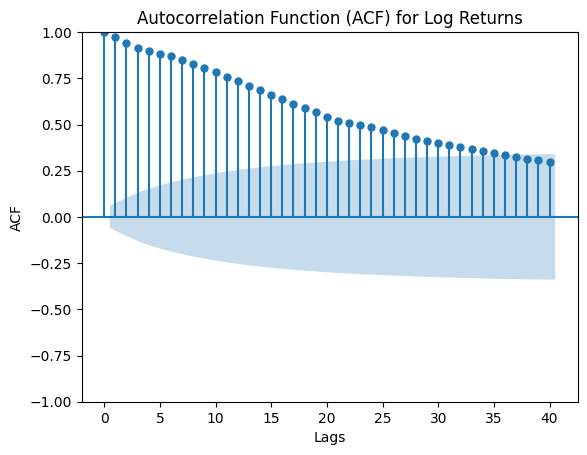

In [64]:
# Calculate ACF values for the log stock returns
acf_values = sm.tsa.stattools.acf(vol_df_3['Daily_Volatility'], fft=False)

# Print the ACF values
print("ACF values:", acf_values)

# Plot the ACF
plot_acf(vol_df_3['Daily_Volatility'], lags=40)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

PACF values: [ 1.          0.97322665 -0.05134963  0.04586755  0.15441312  0.01348251
  0.0269511  -0.05511711 -0.00989825 -0.08322666 -0.0374402  -0.05476198
 -0.03620516 -0.01557383 -0.00882321 -0.02166789 -0.02248037  0.00968048
 -0.04963215  0.05204908 -0.0219711  -0.02257598  0.25249377 -0.05011515
  0.05554222 -0.02723923 -0.04230532 -0.01124104  0.02988012 -0.02310505
 -0.01725199 -0.0017378  -0.0162554   0.01154524 -0.0276038   0.00793002
 -0.01879229 -0.03224205  0.02842536 -0.01951917 -0.02456434]


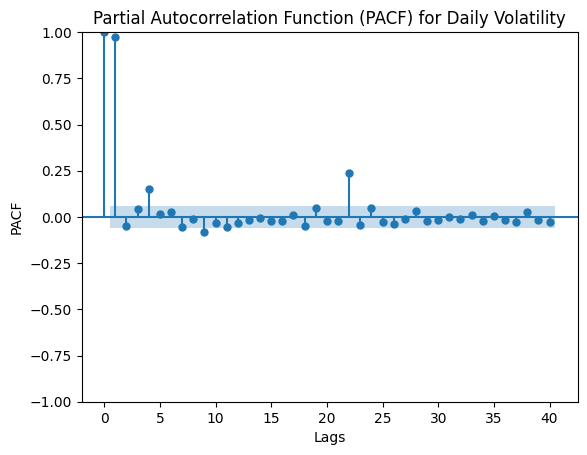

In [65]:
# Calculate ACF values for the log stock returns
pacf_values_vix = sm.tsa.stattools.pacf(vol_df_3['Daily_Volatility'], method='yw', nlags=40)

# Print the ACF values
print("PACF values:", pacf_values_vix)

# Plot the ACF
plot_pacf(vol_df_3['Daily_Volatility'], lags=40)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF) for Daily Volatility')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [66]:
vol_df_3['Daily_Volatility_Lag1'] = vol_df_3['Daily_Volatility'].shift(1)
vol_df_3['Daily_Volatility_Lag2'] = vol_df_3['Daily_Volatility'].shift(2)
vol_df_3['Daily_Volatility_Lag3'] = vol_df_3['Daily_Volatility'].shift(3)
vol_df_3['Daily_Volatility_Lag4'] = vol_df_3['Daily_Volatility'].shift(4)
vol_df_3['Daily_Volatility_Lag7'] = vol_df_3['Daily_Volatility'].shift(7)
vol_df_3['Daily_Volatility_Lag9'] = vol_df_3['Daily_Volatility'].shift(9)
vol_df_3['Daily_Volatility_Lag22'] = vol_df_3['Daily_Volatility'].shift(22)


In [67]:
vol_df_3 = pd.merge(vol_df_3, mxeu_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, smi_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, spx_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, sx7p_df, on='Date', how='left')

In [68]:
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,...,Daily_Volatility_Lag2,Daily_Volatility_Lag3,Daily_Volatility_Lag4,Daily_Volatility_Lag7,Daily_Volatility_Lag9,Daily_Volatility_Lag22,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P
0,2019-01-31,11.3728,17499819.0,-0.033556,0.000000,0.0,0.0,0.0,0.0,0.015024,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001590,0.000397,0.003242,-0.022447
1,2019-02-01,11.3444,10106720.0,-0.002500,0.000000,0.0,0.0,0.0,0.0,0.015115,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005531,0.003016,0.001703,-0.002016
2,2019-02-04,11.2356,9433370.0,-0.009637,0.000000,0.0,0.0,0.0,0.0,0.014520,...,0.015024,NaN,NaN,NaN,NaN,NaN,0.000705,0.001679,0.010166,-0.006225
3,2019-02-05,11.4912,11950471.0,0.022494,0.000000,0.0,0.0,0.0,0.0,0.015138,...,0.015115,0.015024,NaN,NaN,NaN,NaN,0.014785,0.015316,0.006999,0.015130
4,2019-02-06,11.5101,9004917.0,0.001643,0.000000,0.0,0.0,0.0,0.0,0.015045,...,0.014520,0.015115,0.015024,NaN,NaN,NaN,-0.000092,-0.000827,-0.000928,0.008545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0,0.038550,...,0.045623,0.045672,0.045846,0.043012,0.040928,0.041769,-0.025970,-0.012451,-0.010036,-0.062257
1039,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0,0.037596,...,0.034366,0.045623,0.045672,0.046143,0.041371,0.042003,0.017588,0.007932,0.019411,0.027149
1040,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0,0.062776,...,0.038550,0.034366,0.045623,0.046141,0.043012,0.042904,-0.027369,-0.018869,0.011320,-0.069954
1041,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0,0.078020,...,0.037596,0.038550,0.034366,0.045846,0.046143,0.042983,0.016229,0.019091,0.018483,0.015289


In [69]:
del vol_df_3['VIX_Volume']
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,...,Daily_Volatility_Lag2,Daily_Volatility_Lag3,Daily_Volatility_Lag4,Daily_Volatility_Lag7,Daily_Volatility_Lag9,Daily_Volatility_Lag22,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P
0,2019-01-31,11.3728,17499819.0,-0.033556,0.000000,0.0,0.0,0.0,0.0,0.015024,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001590,0.000397,0.003242,-0.022447
1,2019-02-01,11.3444,10106720.0,-0.002500,0.000000,0.0,0.0,0.0,0.0,0.015115,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005531,0.003016,0.001703,-0.002016
2,2019-02-04,11.2356,9433370.0,-0.009637,0.000000,0.0,0.0,0.0,0.0,0.014520,...,0.015024,NaN,NaN,NaN,NaN,NaN,0.000705,0.001679,0.010166,-0.006225
3,2019-02-05,11.4912,11950471.0,0.022494,0.000000,0.0,0.0,0.0,0.0,0.015138,...,0.015115,0.015024,NaN,NaN,NaN,NaN,0.014785,0.015316,0.006999,0.015130
4,2019-02-06,11.5101,9004917.0,0.001643,0.000000,0.0,0.0,0.0,0.0,0.015045,...,0.014520,0.015115,0.015024,NaN,NaN,NaN,-0.000092,-0.000827,-0.000928,0.008545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,2.2570,111961855.0,-0.100653,-1.000000,0.0,1.0,0.0,1.0,0.038550,...,0.045623,0.045672,0.045846,0.043012,0.040928,0.041769,-0.025970,-0.012451,-0.010036,-0.062257
1039,2023-03-14,2.2400,78243911.0,-0.007561,-1.000000,0.0,1.0,0.0,1.0,0.037596,...,0.034366,0.045623,0.045672,0.046143,0.041371,0.042003,0.017588,0.007932,0.019411,0.027149
1040,2023-03-15,1.6970,301403698.0,-0.277614,-1.000000,0.0,1.0,0.0,1.0,0.062776,...,0.038550,0.034366,0.045623,0.046141,0.043012,0.042904,-0.027369,-0.018869,0.011320,-0.069954
1041,2023-03-16,2.0220,218118038.0,0.175225,-0.736842,0.0,1.0,0.0,1.0,0.078020,...,0.037596,0.038550,0.034366,0.045846,0.046143,0.042983,0.016229,0.019091,0.018483,0.015289


In [70]:
vol_df_3.replace([np.inf, -np.inf], np.nan, inplace=True)
vol_df_3.dropna(inplace=True)

In [73]:

# Define the model with sentiment scores and lagged returns as predictors
X = vol_df_3[['Positive_sentiment', 'Negative_sentiment', 'VIX_price', 'Daily_Volatility_Lag1','Daily_Volatility_Lag2' ,'Daily_Volatility_Lag3','Daily_Volatility_Lag4','Daily_Volatility_Lag7','Daily_Volatility_Lag9','Daily_Volatility_Lag22','Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = vol_df_3['Daily_Volatility']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Volatility   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2141.
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        05:44:08   Log-Likelihood:                 4726.1
No. Observations:                1003   AIC:                            -9422.
Df Residuals:                     988   BIC:                            -9349.
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.18

In [74]:

# Define the model with sentiment scores and lagged returns as predictors
X = vol_df_3[['Positive_sentiment_0', 'Negative_sentiment_0', 'VIX_price', 'Daily_Volatility_Lag1','Daily_Volatility_Lag2' ,'Daily_Volatility_Lag3','Daily_Volatility_Lag4','Daily_Volatility_Lag7','Daily_Volatility_Lag9','Daily_Volatility_Lag22','Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = vol_df_3['Daily_Volatility']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Volatility   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2131.
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        05:44:16   Log-Likelihood:                 4725.6
No. Observations:                1003   AIC:                            -9421.
Df Residuals:                     988   BIC:                            -9348.
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   8.25

In [ ]:
# repeat steps and only calculate relevant lags

In [76]:
vol_df_4 = vol_df_2.copy()

In [77]:
vol_df_4 = pd.merge(vol_df_4, vix, on='Date', how='left')


In [78]:
vol_df_4['Daily_Volatility_Lag1'] = vol_df_4['Daily_Volatility'].shift(1)
vol_df_4['Daily_Volatility_Lag7'] = vol_df_4['Daily_Volatility'].shift(7)
vol_df_4['Daily_Volatility_Lag9'] = vol_df_4['Daily_Volatility'].shift(9)
vol_df_4['Daily_Volatility_Lag22'] = vol_df_4['Daily_Volatility'].shift(22)

In [79]:
vol_df_4 = pd.merge(vol_df_4, mxeu_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, smi_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, spx_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, sx7p_df, on='Date', how='left')

In [80]:
del vol_df_4['VIX_Volume']

In [81]:
vol_df_4.replace([np.inf, -np.inf], np.nan, inplace=True)
vol_df_4.dropna(inplace=True)

In [83]:

# Define the model with sentiment scores and lagged returns as predictors
X = vol_df_4[['Positive_sentiment', 'Negative_sentiment', 'VIX_price', 'Daily_Volatility_Lag1','Daily_Volatility_Lag7','Daily_Volatility_Lag9','Daily_Volatility_Lag22','Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = vol_df_4['Daily_Volatility']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Volatility   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1712.
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        06:58:09   Log-Likelihood:                 4721.6
No. Observations:                1003   AIC:                            -9419.
Df Residuals:                     991   BIC:                            -9360.
Df Model:                          11                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.62